# Analyse exploratoire


**1 - Importation des modules**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import os

from utils.data import get_gender, get_states, get_postcode, get_map
from utils.coherence import correct_typo, find_best_similar, gestalt_pattern_matching
from utils.coherence import calculate_age, convert_to_date, postcode_coherence
from utils.eda import apply_gender, find_truth_age, plot_map, match_state

**2 - Spécification des paramètres**

In [2]:
color = (0.1,0.2,0.6)
plt.style.use('seaborn-whitegrid')

**3 - Lecture des données**

In [3]:
file = os.path.join('extern_data','df_patient_pcr.csv')
df = pd.read_csv(file)
df = df.replace({np.nan: None})

In [4]:
df.head()

,patient_id,pcr,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2,born_age,localisation,full_address,full_name
0,653091,N,daniel,campbell,58,sid barnes crescent,north ward,4514,nsw,1.97304e+07,None,08 38772117,None,19730426,4514 nsw north ward,58 sid barnes crescent,campbell daniel
1,347667,N,sebastian,mchenry,12,mundawari circuit,swan view,4551,wa,1.99003e+07,28,08 61083524,ocean star villas,19900316 28,4551 wa swan view,12 mundawari circuit,mchenry sebastian
2,708481,P,sarah,rellos,20,torres street,bribie island,3199,sa,1.94303e+07,None,02 73197286,None,19430317,3199 sa bribie island,20 torres street,rellos sarah
3,148825,N,chloe,brammy,238,fitchett street,carnegie,3280,qld,1.95405e+07,19,02 48826642,None,19540528 19,3280 qld carnegie,238 fitchett street,brammy chloe
4,150081,N,charlie,None,6,clark close,south melbourne,2602,qld,1.97503e+07,35,03 24096098,talawa,19750331 35,2602 qld south melbourne,6 clark close,charlie


In [5]:
df.shape

(8235, 17)

## Pré-traitement des données

Avant de commencer l'analyse exploratoire, nous devons nettoyer la base de données et créer de nouvelles variables pouvant être pertinentes lors de l'analyse. Enfin, nous sélectionnerons les variables utiles afin de créer notre jeu de données final.

### Création d'une variable `Gender`

On commence par corriger les prénoms mal orthographiés avec la fonction utilisée précédemment pour les adresses et la banlieue (`correct_typo`).

Après plusieurs itérations, une similtude à 85% entre deux chaînes de caractère semble convenir en prenant comme base de référence les prénoms apparaissant plus de 3 fois (pour ne pas corriger un prénom par un autre).

In [6]:
given_name_corrected = correct_typo(df.given_name, threshold=3,confidence=85)
df.given_name = df.given_name.replace(given_name_corrected)

On utilise ensuite une [API](https://genderize.io) qui fournit le sexe s'apparentant au mieux à un prénom, avec une probabilité indiquant la confiance de cette prédiction.

*NOTE : Toutefois, l'API limite ses requêtes et une exception est levée lors du seuil journalier atteint. Dans ce cas, la fonction renvoie donc la dernière données sauvegardée.*

In [7]:
unique_name = df.given_name.unique()
all_gender = get_gender(unique_name)

On a donc notre nouvelle variable `gender`.

In [8]:
df["gender"] = apply_gender(all_gender, apply_on=df.given_name)
df[["gender","given_name"]].head()

,gender,given_name
0,male,daniel
1,male,sebastian
2,female,sarah
3,female,chloe
4,male,charlie


### Création de la variable `class_age`

Une seconde étape consiste à mettre en forme les données avant de créer une variable `class_age` calculée selon deux variables : `age` et `date_of_birth`.

In [9]:
df["age_estimated"] = calculate_age(df.date_of_birth, year=2020)
df["age"] = df.age.astype(float)

Pour appliquer la transformation en tranche d'âge (car il y a beaucoup d'erreurs de cohérence entre la date de naissance et l'age renseigné), on utilise le découpage effectué par les documents d'analyse de **Santé Publique France**.

- 0-14 ans
- 15-44 ans 
- 45-64 ans 
- 65-84 ans
- 85+

On considère qu'à partir de 110 ans il s'agit d'une valeur extrème.

In [10]:
df["age_group"] = df.apply(
    lambda x : find_truth_age(x["age"], x["age_estimated"]), 
    axis=1)

df["age_group"] = df.age_group.replace({None: np.nan})

Pour chaque ligne, on compare simultanément **l'age estimé** et **l'age renseigné**.
- si les **deux valeurs concordent** (se trouvent dans la même classe d'âge) alors on applique la tranche d'age pour cette valeur.
- si **une des deux valeurs est manquante**, on impute la classe d'age à partir de la valeur présente.
- si les **deux valeurs ne concordent pas** (se trouve dans des classes d'âges différentes) alors on peut :

     - prendre la moyenne des deux valeurs et imputer la classe par rapport à cette nouvelle valeur (mais cela peut fausser grandement les analyses).
     - vérifier la cohérence de chacune des valeurs et appliquer la plus probable (mais lorsque les deux valeurs sont probables, il est très difficile d'appliquer une règle).
     - remplir par une **valeur manquante**. Il s'agit de la solution retenue, étant la plus prudente.


In [11]:
round(df.age_group.isna().sum() / df.shape[0],3)

0.651

Seulement 45% des valeurs concordent lorsque nous découpons sous forme de classes entre la variable `age` et la variable `age_estimated` calculée à partir de la variable `date_of_birth`.

In [12]:
df[['age','age_estimated','date_of_birth','age_group']][
    df.age_group.isna()].sample(10)

,age,age_estimated,date_of_birth,age_group
1305,39.0,70,19500130.0,NaN
7049,25.0,96,19240131.0,NaN
1468,31.0,72,19481002.0,NaN
4800,28.0,59,19610217.0,NaN
6643,NaN,85,19350413.0,NaN
3572,30.0,77,19431223.0,NaN
1865,NaN,107,19130513.0,NaN
1402,22.0,69,19511208.0,NaN
3900,36.0,118,19020813.0,NaN
686,25.0,81,19392106.0,NaN


On peut voir que sur un échantillon, les différences entre `age` et `age_estimated` ne font ressortir aucun élement pouvant donner un indice sur une bonne information. Il vaut donc mieux laisser ce champ inconnu.

*NB : petite idée, trouver une base comprennant la moyenne d'âge pour un prénom et de réperer quel est l'age le plus concordant avec cette moyenne et imputer selon cette valeur.*

*NB2 : Une seconde pourrait être d'aller vérifier dans la table patient les doublons, pour voir si pour ces valeurs les deux âges concordent*

### Nettoyage des variables : `postcode` et `state`

Nous appliquons ici les étapes que nous avons repérées lors du dernier notebook (correction des erreurs de typographie pour l'état et la vérification des codes postaux).

Pour les **états** : 

In [13]:
dict_ref = get_states()
df["state"] = find_best_similar(df.state, dict_ref, gestalt_pattern_matching)

Pour les **codes postaux** :

In [14]:
str_post = {}

for i in df.postcode.values:
    try :
        int(i)
    except (ValueError, TypeError):
        str_post[i] = None

In [15]:
df["postcode"] = df.replace(str_post)
df["postcode"] = df.postcode.astype(int)

Comme précédemment, les états et les code postaux ne correspondent pas pour tous les patients. On applique donc la fonction que nous avons utilisé pour connaître la cohérence de chacune et appliquer une valeur `None` si les deux informations ne concordent pas.

In [16]:
ref_post = get_postcode()
df["state_by_pc"] = postcode_coherence(
    serie=df.postcode, ref_postcode=ref_post, convert=False)

On peut vérifier le nombre d'incohérences entre états et code postaux.

In [17]:
df["state_verif"] = df.apply(lambda x:
                             match_state(x["state_by_pc"], x["state"]),
                             axis=1)

In [18]:
df.state_verif.isna().sum() / df.shape[0]

0.10151791135397693

### Sélection des variables

La dernière étape consiste à la sélection des variables pour notre jeu de données final : 

- le résultat du test pcr
- le genre prédit du patient
- l'âge
- l'âge estimé par l'année de naissance
- la classe d'âge (si l'age et l'age estimé par l'année de naissance concordent)
- l'état ou demeure le patient (s'il concorde avec le code postal)

In [19]:
df = df[['pcr', 'gender',
         'age_group', 'age', 'age_estimated',
         'state_verif']]
df = df.rename(columns={"state_verif": 'state'})

df.head()

,pcr,gender,age_group,age,age_estimated,state
0,N,male,45-64,NaN,47,NSW
1,N,male,15-44,28.0,30,WA
2,P,female,65-84,NaN,77,SA
3,N,female,NaN,19.0,66,QLD
4,N,male,NaN,35.0,45,QLD


## Visualisation des données

La dernière étape consiste à la visualisation des données.

### Prévalence selon la localisation

On commence par importer notre map de l'Australie.

In [21]:
map_df = get_map(dict_ref)

In [22]:
pcr_count_P = df[df.pcr == "P"].groupby('state').count().pcr
pcr_data_P = map_df.merge(pcr_count_P, on='state')

pourc_pos = np.round(df[df.pcr == 'P'].groupby('state').count().pcr
                     / df.groupby('state').count().pcr, 3)
pos_ratio_data = map_df.merge(pourc_pos, on='state')

On peut afficher le nombre de patients testés positif pour chaque état

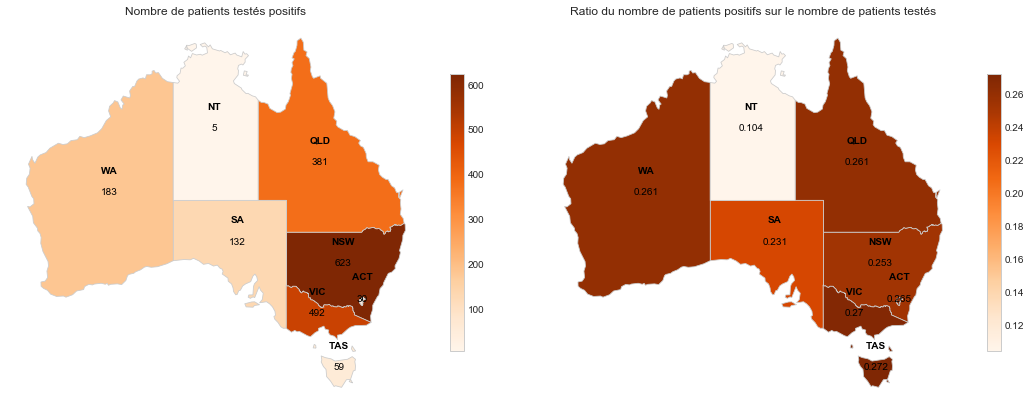

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

plot_map(pcr_data_P, 'pcr', cmap='Oranges',
         color_font="black", size_fig=(12, 8),
         title='Nombre de patients testés positifs', ax=ax[0],
         fig=fig, size_colorbar=0.5)

plot_map(pos_ratio_data, 'pcr', cmap="Oranges",
         color_font="black", size_fig=(12, 8),
         title="Ratio du nombre de patients positifs sur le nombre \
de patients testés",
         ax=ax[1], fig=fig, size_colorbar=0.5)

fig.tight_layout()

> À partir de ces deux cartes on constate que la majorités des tests (dont on connaît la localisation du patient) on été effectués dans les états du Sud-Ouest (NSW, ACT et VIC).

> D'autre part, le ratio nombre de cas positif sur le nombre de test par état révèle que tous les états sont touchés, hormis l'état du nord (NT). En moyenne, on constate 1/4 de patients positifs à la Covid 19.

Pour améliorer cette partie, il serait possible prendre en compte la populuation des états pour connaître le nombre de cas positif sur l'ensemble de la population. 

### Prévalence selon le genre et l'âge

Cette dernière partie vise à analyser les données concernant les caractéristique des patients (age et genre).

In [24]:
df_N = df[df.pcr == 'N']
df_P = df[df.pcr == 'P']

crosstab_P = pd.crosstab(df_P.gender, df_P.age_group, normalize=True) 

Dans les deux figures ci-dessous on peut conclure que : 

> Les hommes sont légèrement plus testés que les femmes et le pourcentage de cas positif est similaire entre les deux genres.

> Si nous observations les cas positifs, la tranche d'âge 15-44 ans est la plus impactée (plus de 75% des cas positifs). Ensuite, vient la population plus âgée (65-85 ans). Les plus jeunes sont les moins touchés par le virus. 

>On peut expliquer ce résultat d'une part car la tranche d'âge la plus touchée concerne les actifs. Les actifs sont les personnes qui cotoient (le plus généralement) de nombreuses personnes. Par exemple, dans le cadre de leur activité professionnel. Ceci augmente donc la probabilité d'être touché par le virus. 

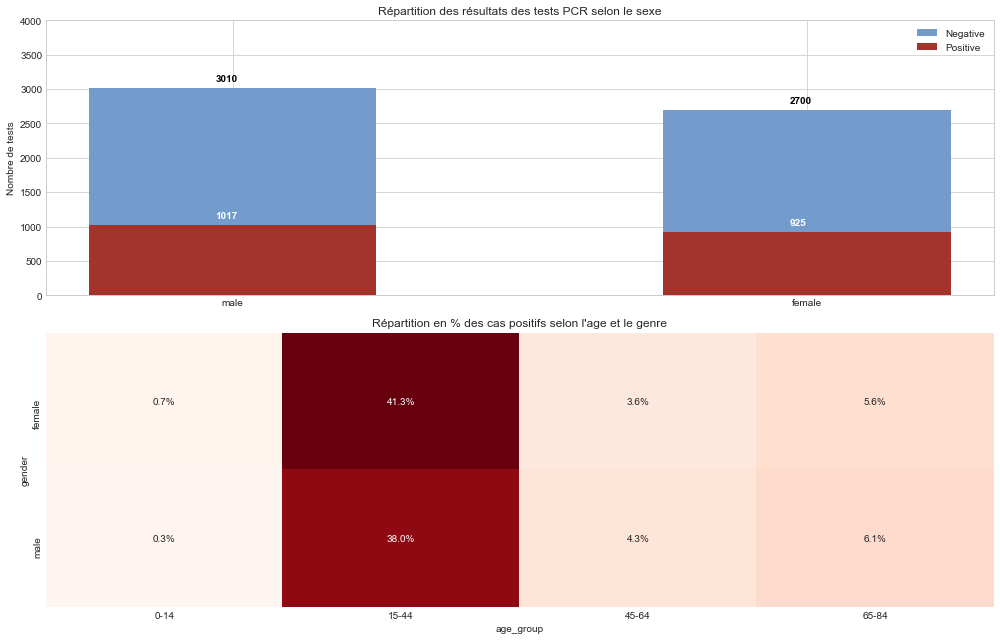

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(14, 9))

plot_bar_PN(df_N, df_P, 'gender',
            y=100, x=-0.03, sort=False, print_none=False,
            title='Répartition des résultats des tests PCR selon le sexe',
            ax=ax[0])

plot_crosstab(
    crosstab_P, ax=ax[1], title="Répartition en % des cas positifs selon l'age et le genre")

fig.tight_layout()

On peut observer également la distributions des âges et la répartition des tranches d'âges.

> Les âges renseignés par les patients montre une distribution fortement centré à 30 ans et un petit pic pour les jeunes (10 ans environ). Au contraire, les âges estimés par l'année de naissance montre une distribution uniforme entre 20 et 120 ans. On peut conclure que ces deux distributions sont très divergentes

> Les graphique en barres concernant les tranches d'âge montrent seulement les cas lorsque l'age renseigné et l'age estimé par la date de naissance concordent. Les tranches d'âges retenues sont celles des études réalisées par Santé Publique France. On constate que la grande majorité des tests sont effectués sur des patients entre 15 et 44 ans, et le nombre de cas positif également.

In [37]:
age = df.age[df.age.notnull()]
age_es = df.age_estimated[df.age_estimated.notnull()]

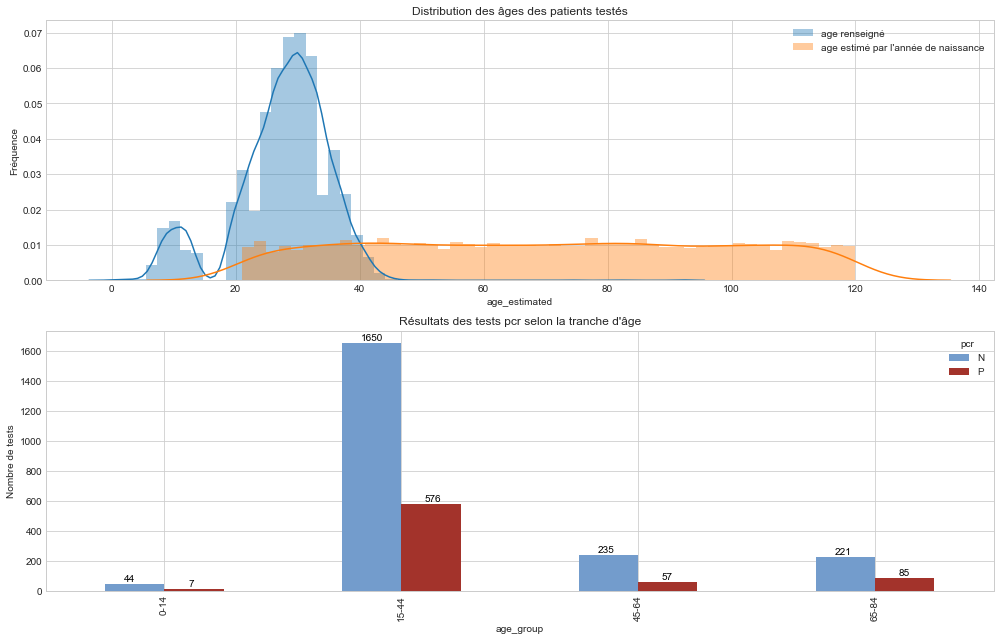

In [178]:
fig, ax = plt.subplots(2, 1, figsize=(14, 9))

plot_dist(age, age_es,
          title='Distribution des âges des patients testés',
          label=('age renseigné', "age estimé par l'année de naissance"), ax=ax[0])
ax[0].set_ylabel('Fréquence')


plot_hist_age(df, ax[1], x=(-0.17, 20), y=(0.1, 20),
              ylabel='Nombre de tests',
              title="Résultats des tests pcr selon la tranche d'âge")

plt.tight_layout()